# SageMaker/DeepAR demo on Stores Daily Sales

In this lab, we will use Amazon SageMaker build-in algorithm DeepAR to forecast 1604 stores daily sales.

In particular, we will see how to:
* Use the SageMaker Python SDK to train a DeepAR model and deploy it
* Make requests to the deployed model to obtain forecasts interactively
* Illustrate advanced features of DeepAR: additional time features and category information

Running this notebook takes around 40 min on a ml.c4.2xlarge for the training, and inference is done on a ml.m4.xlarge (the usage time will depend on how long you leave your served model running).

For more information see the DeepAR [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html) or [paper](https://arxiv.org/abs/1704.04110), 

In [1]:
%matplotlib inline

import sys
from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [2]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [3]:
sagemaker_session = sagemaker.Session()

Before starting, we can override the default values for the following:
- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.

In [4]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'tko-ts-workshop'    # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

In [5]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

Next, we configure the container image to be used for the region that we are running in.

In [6]:
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

### Import dataset and upload it to S3 to make it available for Sagemaker

We already has pre-processed the data we will use, it is under the same folder.

In [7]:
FILE_NAME = 'data/timeseries_raw.csv'

Then, we load and parse the dataset and convert it to a collection of Pandas time series, which makes common time series operations such as indexing by time periods or resampling much easier. The data has been processed, and the frequency is 1 day.

In [81]:
data = pd.read_csv(FILE_NAME, sep=",", index_col=0, parse_dates=True, decimal=',')
data.index = pd.DatetimeIndex(data.index,freq="1D")

num_timeseries = data.shape[1]

timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data.iloc[:,i], trim='f').astype(float))

Let us plot the resulting time series for the first ten stores.

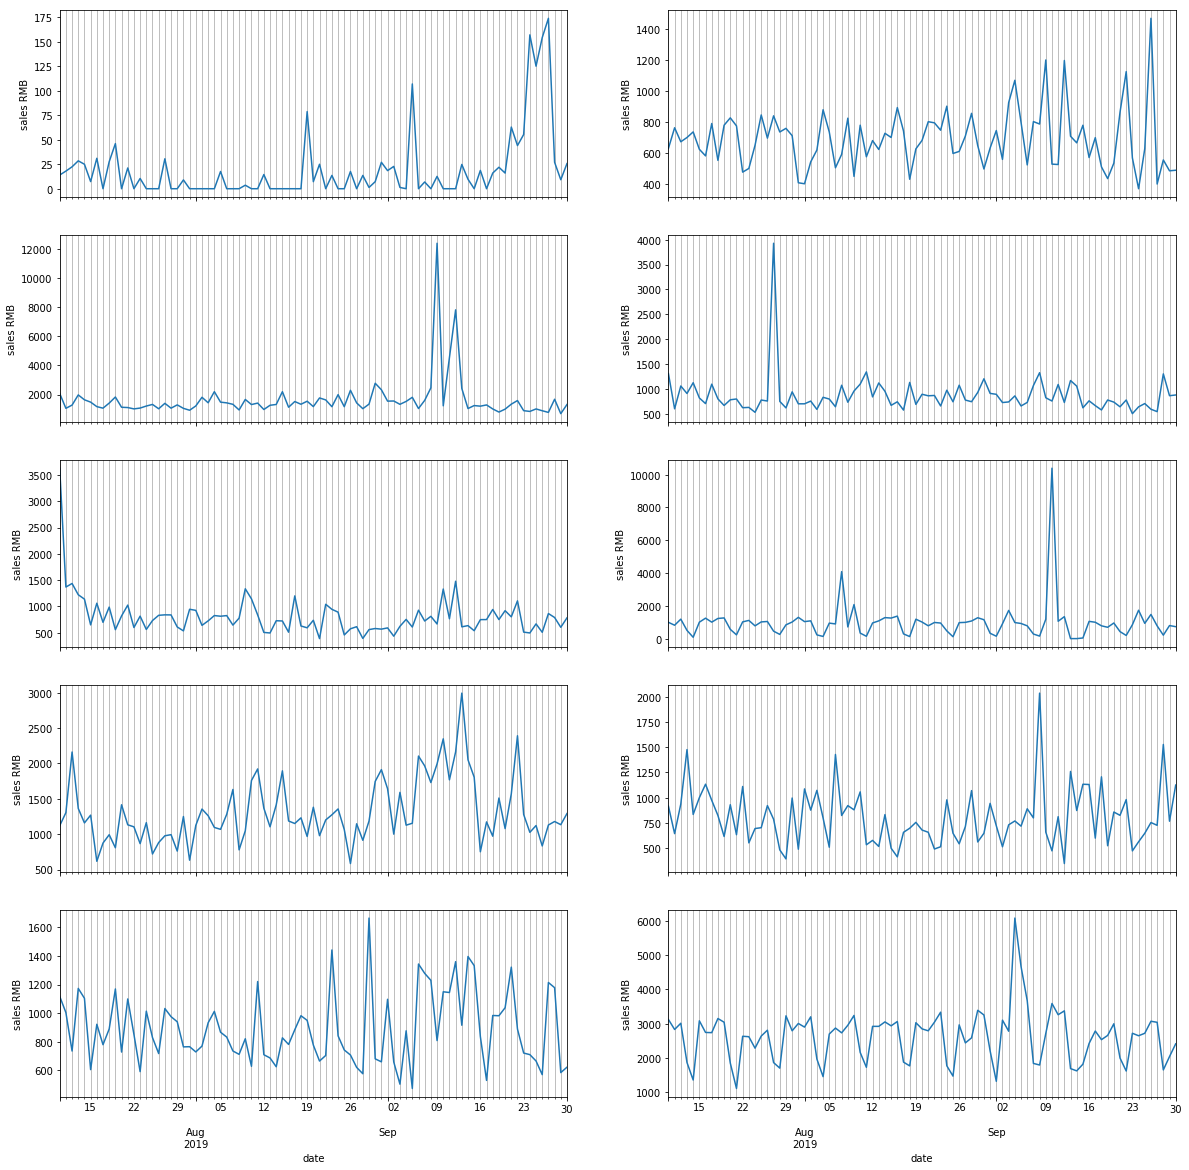

In [317]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    timeseries[i].loc["2019-07-10":"2019-09-30"].astype(float).plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("sales RMB")   
    axx[i].grid(which='minor', axis='x')

### Train and Test splits

Often times one is interested in evaluating the model or tuning its hyperparameters by looking at error metrics on a hold-out test set. Here we split the available data into train and test sets for evaluating the trained model. For standard machine learning tasks such as classification and regression, one typically obtains this split by randomly separating examples into train and test sets. However, in forecasting it is important to do this train/test split based on time rather than by time series.

In this example, we will reserve the last section of each of the time series for evalutation purpose and use only the first part as training data. 

In [320]:
# we use 1 day frequency for the time series
freq = '1D'

# we predict for 7 days
prediction_length = 7

# we also use 14 days as context length, this is the number of state updates accomplished before making predictions
context_length = 14

We specify here the portion of the data that is used for training: the model sees data from 2019-07-10 to 2019-09-16 for training.

In [13]:
start_dataset = pd.Timestamp("2019-07-10 00:00:00", freq=freq)
end_training = pd.Timestamp("2019-09-17 00:00:00", freq=freq)
end_test = pd.Timestamp("2019-10-01 00:00:00", freq=freq)

The DeepAR JSON input format represents each time series as a JSON object. In the simplest case each time series just consists of a start time stamp (``start``) and a list of values (``target``). For more complex cases, DeepAR also supports the fields ``dynamic_feat`` for time-series features and ``cat`` for categorical features, which we will use  later.

In [14]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training - 1].tolist()  # We use -1, because pandas indexing includes the upper bound 
    }
    for ts in timeseries
]
print(len(training_data))

1604


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


As test data, we will consider time series extending beyond the training range: these will be used for computing test scores, by using the trained model to forecast their trailing 7 days, and comparing predictions with actual values.
To evaluate our model performance on more than one week, we generate test data that extends to 1, 2 weeks beyond the training range. This way we perform *rolling evaluation* of our model.

In [15]:
num_test_windows = 2

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training + k * prediction_length].tolist()
    }
    for k in range(1, num_test_windows + 1) 
    for ts in timeseries
]
print(len(test_data))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


3208


Let's now write the dictionary to the `jsonlines` file format that DeepAR understands (it also supports gzipped jsonlines and parquet).

In [16]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [17]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 58.7 ms, sys: 0 ns, total: 58.7 ms
Wall time: 65 ms


Now that we have the data files locally, let us copy them to S3 where DeepAR can access them. Depending on your connection, this may take a couple of minutes.

In [18]:
s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [19]:
%%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

File s3://sagemaker-us-west-2-169088282855/s3://sagemaker-us-west-2-169088282855/tko-ts-workshop/data/train/train.json already exists.
Set override to upload anyway.

File s3://sagemaker-us-west-2-169088282855/s3://sagemaker-us-west-2-169088282855/tko-ts-workshop/data/test/test.json already exists.
Set override to upload anyway.

CPU times: user 17.7 ms, sys: 4.05 ms, total: 21.8 ms
Wall time: 111 ms


Let's have a look to what we just wrote to S3.

In [20]:
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(s3_data_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2019-07-10 00:00:00", "target": ["14.0", "18.0", "22.4", "28.5", "25.0", "7.3", "31.1", "...


We are all set with our dataset processing, we can now call DeepAR to train a model and generate predictions.

### Train a model

Here we define the estimator that will launch the training job.

In [321]:
sagemaker_session = sagemaker.Session()
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-stores-sales-demo',
    output_path=s3_output_path
)

Next we need to set the hyperparameters for the training job. For example frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options (number of epochs, batch size, learning rate...). We use default parameters for every optional parameter in this case (you can always use [Sagemaker Automated Model Tuning](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune them).

In [322]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "32",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [323]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test. This is done by predicting the last `prediction_length` points of each time-series in the test set and comparing this to the actual value of the time-series. 

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, training options.

In [324]:
%%time
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels, wait=True)

2019-12-19 09:34:41 Starting - Starting the training job...
2019-12-19 09:34:42 Starting - Launching requested ML instances......
2019-12-19 09:36:04 Starting - Preparing the instances for training......
2019-12-19 09:37:00 Downloading - Downloading input data...
2019-12-19 09:37:40 Training - Training image download completed. Training in progress..Arguments: train
[12/19/2019 09:37:43 INFO 140114819016512] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience':

Since you pass a test set in this example, accuracy metrics for the forecast are computed and logged (see bottom of the log).
You can find the definition of these metrics from [our documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). You can use these to optimize the parameters and tune your model or use SageMaker's [Automated Model Tuning service](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune the model for you.

### Create endpoint and predictor

Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

**Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.**

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [25]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

Now we can deploy the model and create and endpoint that can be queried using our custom DeepARPredictor class.

In [325]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor)

-------------------------------------------------------------------------------------------------------------!

### Make predictions and plot results

Now we can use the `predictor` object to generate predictions.

In [326]:
predictor.predict(ts=timeseries[0][start_dataset:end_training],quantiles=[0.10, 0.5, 0.90])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:46: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


,0.1,0.9,0.5
2019-09-17,-17.381962,41.310123,11.391643
2019-09-18,-21.770470,40.213966,6.815208
2019-09-19,-27.721313,31.059887,4.678380
2019-09-20,-33.716675,47.358875,8.939394
2019-09-21,-23.695591,42.659607,7.156330
2019-09-22,-29.904499,48.839691,4.955435
2019-09-23,-22.125050,45.779213,9.776169


Below we define a plotting function that queries the model and displays the forecast.

In [89]:
def plot(
    predictor, 
    target_ts, 
    cat=None, 
    dynamic_feat=None, 
    forecast_date=end_training, 
    show_samples=False, 
    plot_history=7 * 12,
    confidence=80
):
    print("calling served model to generate predictions starting from {}".format(str(forecast_date)))
    assert(confidence > 50 and confidence < 100)
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
        
    # we first construct the argument to call our model
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": 100
    }


    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 3))
        ax = plt.subplot(1,1,1)
    
    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, 'cat = {}'.format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    if show_samples: 
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color='lightskyblue', alpha=0.2, label='_nolegend_')
                
                
    # plot the target
    target_section = target_ts[forecast_date-plot_history:forecast_date+prediction_length]
    target_section.plot(color="black", label='target')
    
    # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color="b", alpha=0.3, label='{}% confidence interval'.format(confidence)
    )
    prediction["0.5"].plot(color="b", label='P50')
    ax.legend(loc=2)    
    
    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)
    
    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.DatetimeIndex(start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)),
                data=f
            )
            feat_ts[forecast_date-plot_history:forecast_date+prediction_length].plot(ax=ax, color='g')

We can interact with the function previously defined, to look at the forecast of any customer at any point in (future) time. 

For each request, the predictions are obtained by calling our served model on the fly.

Here we forecast the consumption of an office after week-end (note the lower week-end consumption). 
You can select any time series and any forecast date, just click on `Run Interact` to generate the predictions from our served endpoint and see the plot.

In [90]:
style = {'description_width': 'initial'}

In [327]:
@interact_manual(
    customer_id=IntSlider(min=0, max=1603, value=120, style=style), 
    forecast_day=IntSlider(min=0, max=14, value=7, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_days_plot=IntSlider(min=1, max=50, value=7, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False
)
def plot_interact(customer_id, forecast_day, confidence, history_days_plot, show_samples):
    plot(
        predictor,
        target_ts=timeseries[customer_id],
        forecast_date=end_training + datetime.timedelta(days=forecast_day),
        show_samples=show_samples,
        plot_history=history_days_plot,
        confidence=confidence
    )

interactive(children=(IntSlider(value=120, description='customer_id', max=1603, style=SliderStyle(description_…

## Check metrics

In [328]:
%%time

preds = []
quantiles=[0.10, 0.5, 0.90]

for i, ts_dict in enumerate(timeseries):
    ts = ts_dict[start_dataset:end_test-1]
    if ts.shape[0] == 0:
        preds.append(None)
        continue
    pred = predictor.predict(ts=ts[start_dataset:end_training], quantiles=quantiles)  # , dynamic_feat=dynamic_feat
    preds.append(pred)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:46: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


CPU times: user 5.88 s, sys: 117 ms, total: 6 s
Wall time: 43.2 s


Print first 10 stores inference performance, you can print more if you want.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 0
RMSE: 32.281434992631155
MAE: 26.502960845414286
Target Mean: 30.921428571428574
               y_pred  y_label
2019-09-17  11.391643     0.00
2019-09-18   6.815208    16.00
2019-09-19   4.678380    21.95
2019-09-20   8.939394    16.00
2019-09-21   7.156330    63.00
2019-09-22   4.955435    44.10
2019-09-23   9.776169    55.40


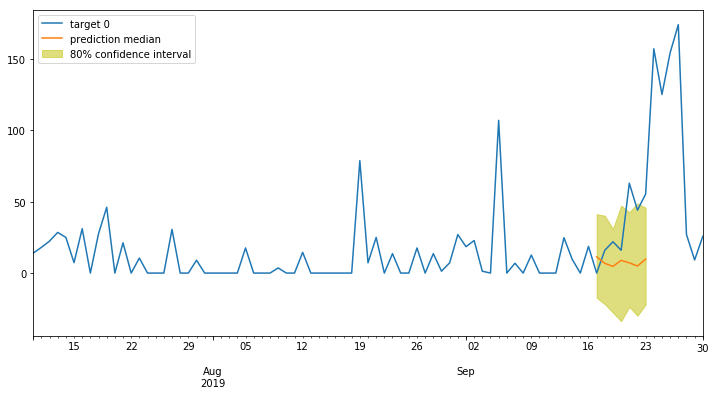

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 1
RMSE: 294.48780937515306
MAE: 239.81528320311432
Target Mean: 677.7428571428571
                y_pred  y_label
2019-09-17  755.152527    700.3
2019-09-18  865.791992    511.4
2019-09-19  983.143127    435.7
2019-09-20  802.624695    535.6
2019-09-21  863.784668    864.7
2019-09-22  853.527100   1127.3
2019-09-23  749.506409    569.2


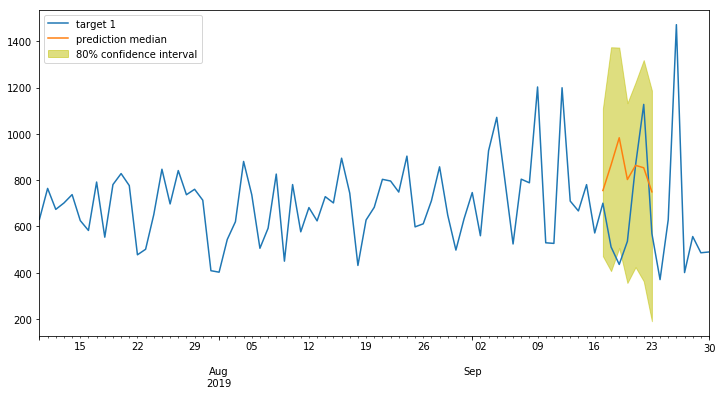

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 2
RMSE: 1449.8661834736356
MAE: 1308.0678955078001
Target Mean: 1133.4714285714285
                 y_pred  y_label
2019-09-17  1696.233276   1289.6
2019-09-18  2115.463379   1014.5
2019-09-19  3005.589111    800.9
2019-09-20  2512.682861   1001.1
2019-09-21  2323.947266   1341.9
2019-09-22  2404.146484   1590.1
2019-09-23  3032.712891    896.2


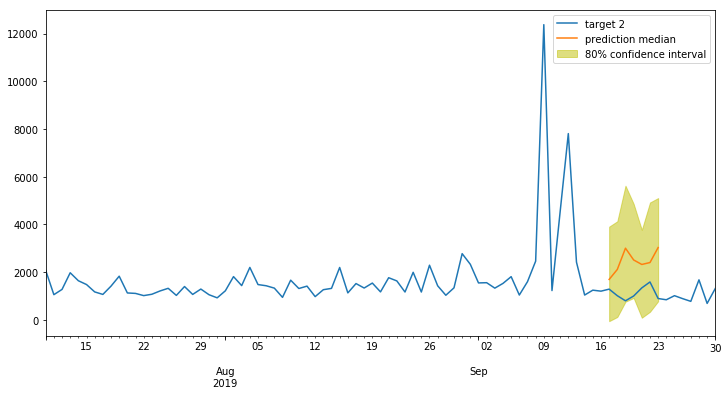

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 3
RMSE: 320.66922352267704
MAE: 292.04828578405716
Target Mean: 664.4714285714284
                 y_pred  y_label
2019-09-17   878.793701    660.9
2019-09-18   873.784180    573.8
2019-09-19   896.031372    774.1
2019-09-20  1026.500610    732.0
2019-09-21  1191.322021    637.3
2019-09-22   953.963745    774.0
2019-09-23   875.242371    499.2


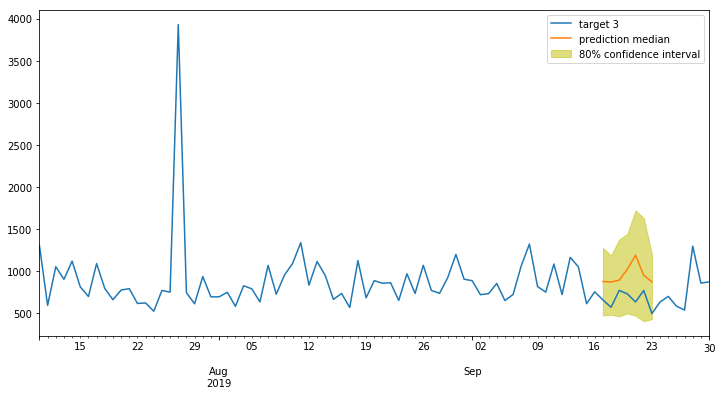

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 4
RMSE: 179.2927771991038
MAE: 135.1646658761143
Target Mean: 825.9857142857144
                y_pred  y_label
2019-09-17  858.187561    750.3
2019-09-18  804.170349    942.1
2019-09-19  822.598450    749.8
2019-09-20  928.613220    919.5
2019-09-21  743.797974    802.1
2019-09-22  706.533020   1106.4
2019-09-23  671.954773    511.7


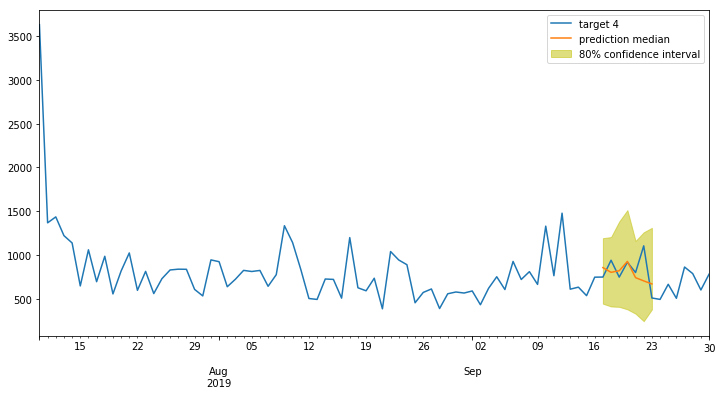

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 5
RMSE: 460.00214536164896
MAE: 405.80569196427143
Target Mean: 698.1000000000001
                 y_pred  y_label
2019-09-17  1734.855713    998.2
2019-09-18  1134.552856    779.8
2019-09-19  1015.580505    691.3
2019-09-20   973.775635    951.9
2019-09-21   721.525085    426.3
2019-09-22   802.293091    192.5
2019-09-23  1344.756958    846.7


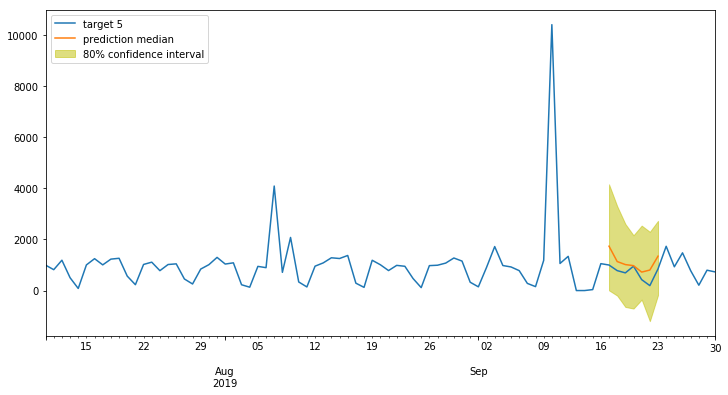

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 6
RMSE: 609.8037709971438
MAE: 546.1198556082571
Target Mean: 1424.357142857143
                 y_pred  y_label
2019-09-17  1635.587158   1173.2
2019-09-18  1542.725098    971.0
2019-09-19  1790.877930   1510.4
2019-09-20  2223.656738   1078.5
2019-09-21  2156.017090   1569.4
2019-09-22  1886.666504   2390.5
2019-09-23  1550.141479   1277.5


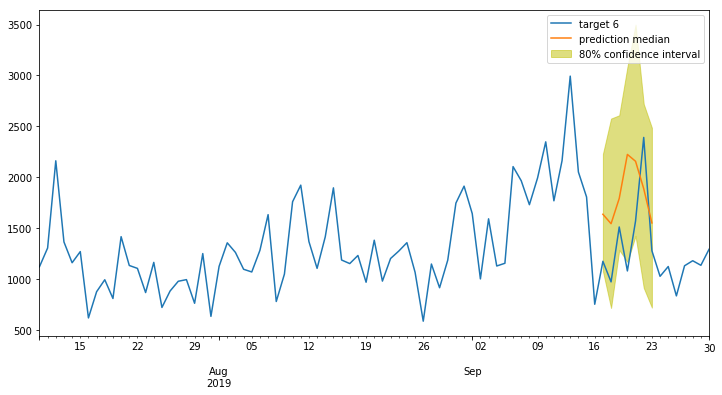

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 7
RMSE: 235.83320940050882
MAE: 219.38202253068576
Target Mean: 779.6285714285715
                 y_pred  y_label
2019-09-17   813.498230    597.5
2019-09-18   852.976685   1206.5
2019-09-19   761.186035    521.8
2019-09-20   953.294373    856.8
2019-09-21  1074.832764    823.8
2019-09-22  1080.182129    980.4
2019-09-23   750.057312    470.6


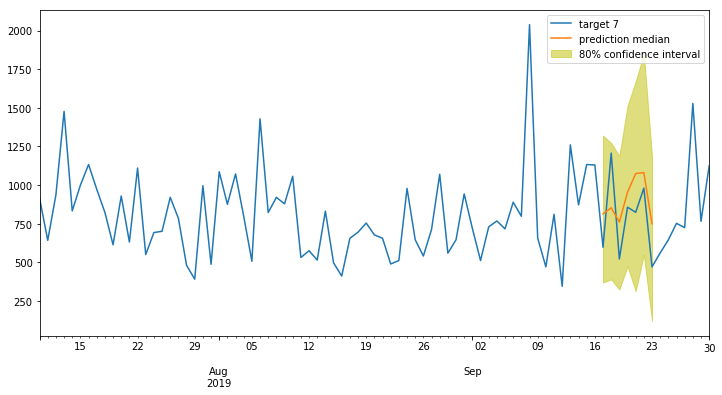

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 8
RMSE: 232.57707646504468
MAE: 196.1373517717571
Target Mean: 924.0571428571429
                 y_pred  y_label
2019-09-17   968.933411    530.7
2019-09-18   989.067261    984.2
2019-09-19  1136.730591    982.4
2019-09-20  1261.956787   1038.4
2019-09-21  1192.802856   1321.9
2019-09-22  1158.411499    889.1
2019-09-23   875.264771    721.7


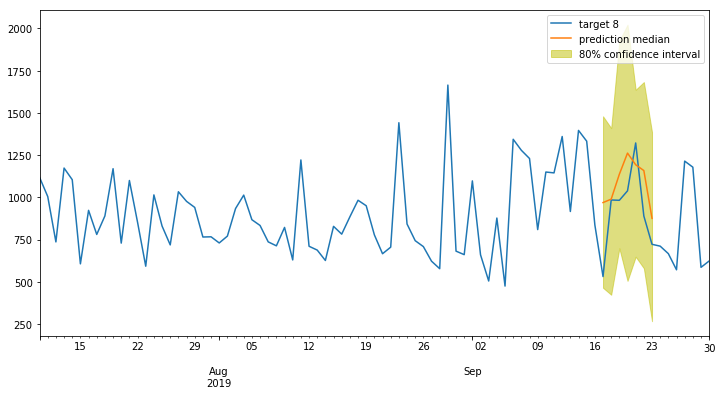

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 9
RMSE: 630.5456383521127
MAE: 537.9841657366
Target Mean: 2473.714285714286
                 y_pred  y_label
2019-09-17  3021.203369   2786.8
2019-09-18  3616.516357   2534.6
2019-09-19  3477.408936   2657.7
2019-09-20  3087.552002   2998.2
2019-09-21  2453.873535   1998.7
2019-09-22  2363.309570   1618.7
2019-09-23  3062.025391   2721.3


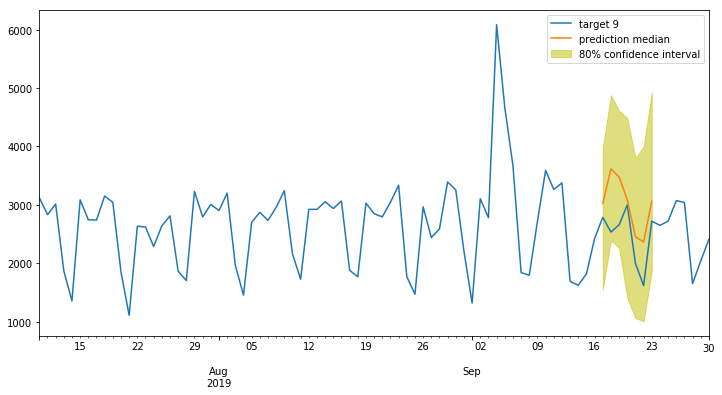

CPU times: user 4.83 s, sys: 104 ms, total: 4.93 s
Wall time: 4.89 s


In [331]:
%%time
from sklearn import metrics

def show_metrics(target_quantile='0.5'):
    for i in range(10):  # TODO len(timeseries)
        if preds[i] is None:
            continue
        
        s = timeseries[i][start_dataset:end_test-1].fillna(0)
        
        print("i:", i)
        p10 = preds[i]['0.1']
        p90 = preds[i]['0.9']
        y_label =  timeseries[i][end_training+1:end_training+7].fillna(0)
        y_pred = preds[i][target_quantile]
        if y_label.shape[0] != y_pred.shape[0]:
            continue
        
        print("RMSE:",np.sqrt(metrics.mean_squared_error(y_label, y_pred)))
        print("MAE:",metrics.mean_absolute_error(y_label, y_pred))
        print("Target Mean:",y_label.mean())
        print(pd.DataFrame({'y_pred': y_pred, 'y_label': y_label}))
        plt.figure(figsize=(12,6))
        s.plot(label='target %s'%str(i))
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        y_pred.plot(label='prediction median')
        plt.legend()
        plt.show()

show_metrics(target_quantile='0.5')

# Additional features

We have seen how to prepare a dataset and run DeepAR for a simple example.

In addition DeepAR supports the following features:

* missing values: DeepAR can handle missing values in the time series during training as well as for inference.
* Additional time features: DeepAR provides a set default time series features such as hour of day etc. However, you can provide additional feature time series via the `dynamic_feat` field. 
* generalize frequencies: any integer multiple of the previously supported base frequencies (minutes `min`, hours `H`, days `D`, weeks `W`, month `M`) are now allowed; e.g., `15min`. We already demonstrated this above by using `1D` frequency.
* categories: If your time series belong to different groups (e.g. types of product, regions, etc), this information can be encoded as one or more categorical features using the `cat` field.

We will now demonstrate categories and time features support. For this part we will reuse the stores sales dataset, we get categories of the stores from data owner and crawler weather data from http://lishi.tianqi.com/shenzhen as dynamic time series: 
* weather time series will contain: the high temperature, the low temperature of the day, whether is rainy, whether is sunshine, whether is cloudy;
* besides that, we add addtional time series that whether the day is weekend;
* categories: 31D array for each target series;

dynamic_feat: total 6 dynamic_feat, the high temperature, the low temperature, is_sunshine, is_rain, is_cloudy, is_weekend. 

## Prepare dataset

We will read those data as we have prepared in advance. 

cat is stand for category, here it is a one 31d vector for each store time series.

In [334]:
cat = pd.read_csv('cat.csv', sep=",", index_col=0, parse_dates=True)
cat_num_timeseries = cat.shape[0]
cat_timeseries = []
for i in range(cat_num_timeseries):
    cat_timeseries.append(cat.loc[i])

In [333]:
is_weekend = pd.read_csv('is_weekend.csv', sep=",", index_col=0, parse_dates=True)
is_weekend_timeseries = is_weekend.iloc[:,0]
is_weekend_timeseries

date
2019-07-10    0
2019-07-11    0
2019-07-12    0
2019-07-13    1
2019-07-14    1
2019-07-15    0
2019-07-16    0
2019-07-17    0
2019-07-18    0
2019-07-19    0
2019-07-20    1
2019-07-21    1
2019-07-22    0
2019-07-23    0
2019-07-24    0
2019-07-25    0
2019-07-26    0
2019-07-27    1
2019-07-28    1
2019-07-29    0
2019-07-30    0
2019-07-31    0
2019-08-01    0
2019-08-02    0
2019-08-03    1
2019-08-04    1
2019-08-05    0
2019-08-06    0
2019-08-07    0
2019-08-08    0
             ..
2019-09-01    1
2019-09-02    0
2019-09-03    0
2019-09-04    0
2019-09-05    0
2019-09-06    0
2019-09-07    1
2019-09-08    1
2019-09-09    0
2019-09-10    0
2019-09-11    0
2019-09-12    0
2019-09-13    0
2019-09-14    1
2019-09-15    1
2019-09-16    0
2019-09-17    0
2019-09-18    0
2019-09-19    0
2019-09-20    0
2019-09-21    1
2019-09-22    1
2019-09-23    0
2019-09-24    0
2019-09-25    0
2019-09-26    0
2019-09-27    0
2019-09-28    1
2019-09-29    1
2019-09-30    0
Name: is_weekend, L

In [340]:
weather = pd.read_csv('shenzhen_weather.csv', sep=",", index_col=0, parse_dates=True)
w_num_timeseries = weather.shape[1]
w_timeseries = []
for i in range(w_num_timeseries):
    w_timeseries.append(weather.iloc[:,i])

In [341]:
train_dynamic_feat= []
for i in range(5):
    train_dynamic_feat.append(w_timeseries[i][start_dataset:end_training].tolist())
train_dynamic_feat.append(is_weekend_timeseries[start_dataset:end_training].tolist())

In [343]:
test_dynamic_feat= []
for i in range(5):
    test_dynamic_feat.append(w_timeseries[i][start_dataset:end_test].tolist())
test_dynamic_feat.append(is_weekend_timeseries[start_dataset:end_test].tolist())

The DeepAR JSON input format represents each time series as a JSON object. In the case each time series consists of a start time stamp (``start``) and a list of values (``target``)as well as ``dynamic_feat`` for time-series features and ``cat`` for categorical features.

In [344]:
%%time

training_data_new_features = [
    {
        "start": str(start_dataset),
        "target": timeseries[i][start_dataset:end_training].tolist(),
        "cat": cat_timeseries[i].tolist(),
        "dynamic_feat": train_dynamic_feat
    }
    for i in range(cat_num_timeseries)
]
print(len(training_data_new_features))

1604
CPU times: user 313 ms, sys: 0 ns, total: 313 ms
Wall time: 312 ms


In [345]:
# as in our previous example, we do a rolling evaluation over the next 7 days
num_test_windows = 2

df = []
for k in range(1, num_test_windows + 1):
    aa = []
    for i in range(6):
        aa .append(test_dynamic_feat[i][0:(end_training - start_dataset).days + 1 + k * prediction_length])
    df.append(aa)
    
test_data_new_features = [
    {
        "start": str(start_dataset),
        "target": timeseries[i][start_dataset:end_training + k * prediction_length].tolist(),
        "cat": cat_timeseries[i].tolist(),
        "dynamic_feat": df[k-1]
    }
    for k in range(1, num_test_windows + 1) 
    for i in range(cat_num_timeseries)
]
print(len(test_data_new_features))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


3208


In [346]:
def check_dataset_consistency(train_dataset, test_dataset=None):
    d = train_dataset[0]
    has_dynamic_feat = 'dynamic_feat' in d
    if has_dynamic_feat:
        num_dynamic_feat = len(d['dynamic_feat'])
    has_cat = 'cat' in d
    if has_cat:
        num_cat = len(d['cat'])
    
    def check_ds(ds):
        for i, d in enumerate(ds):
            if has_dynamic_feat:
                assert 'dynamic_feat' in d
                assert num_dynamic_feat == len(d['dynamic_feat'])
                for f in d['dynamic_feat']:
                    assert len(d['target']) == len(f)
                    
            if has_cat:
                assert 'cat' in d
                assert len(d['cat']) == num_cat
    check_ds(train_dataset)
    if test_dataset is not None:
        
        check_ds(test_dataset)
        
check_dataset_consistency(training_data_new_features, test_data_new_features)

Write the new train and test data to local disk.

In [347]:
%%time
write_dicts_to_file("train_new_features.json", training_data_new_features)
write_dicts_to_file("test_new_features.json", test_data_new_features)

CPU times: user 359 ms, sys: 16.1 ms, total: 375 ms
Wall time: 409 ms


Upload the new train and test data to S3 bucket, here we will use new bucket which has a extend name '-new-features' of the bucket name you used in before case.

In [348]:
%%time

s3_data_path_new_features = "s3://{}/{}-new-features/data".format(s3_bucket, s3_prefix)
s3_output_path_new_features = "s3://{}/{}-new-features/output".format(s3_bucket, s3_prefix)

print('Uploading to S3 this may take a few minutes depending on your connection.')
copy_to_s3("train_new_features.json", s3_data_path_new_features + "/train/train_new_features.json", override=True)
copy_to_s3("test_new_features.json", s3_data_path_new_features + "/test/test_new_features.json", override=True)

Uploading to S3 this may take a few minutes depending on your connection.
Overwriting existing file
Uploading file to s3://sagemaker-us-west-2-169088282855/tko-ts-workshop-new-features/data/train/train_new_features.json
Overwriting existing file
Uploading file to s3://sagemaker-us-west-2-169088282855/tko-ts-workshop-new-features/data/test/test_new_features.json
CPU times: user 81.3 ms, sys: 4.32 ms, total: 85.6 ms
Wall time: 399 ms


Agagin, let's setup the estimator and hyperparameters, then let's fit it.

In [349]:
%%time
estimator_new_features = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-stores-sales-demo',
    output_path=s3_output_path_new_features
)

hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "epochs": "400",
    "learning_rate": "5E-4",
    "mini_batch_size": "32",
    "early_stopping_patience": "40",
    "num_dynamic_feat": "auto",  # this will use the `dynamic_feat` field if it's present in the data
}
estimator_new_features.set_hyperparameters(**hyperparameters)

estimator_new_features.fit(
    inputs={
        "train": "{}/train/".format(s3_data_path_new_features),
        "test": "{}/test/".format(s3_data_path_new_features)
    }, 
    wait=True
)

2019-12-19 10:54:31 Starting - Starting the training job...
2019-12-19 10:54:33 Starting - Launching requested ML instances......
2019-12-19 10:55:52 Starting - Preparing the instances for training...
2019-12-19 10:56:28 Downloading - Downloading input data......
2019-12-19 10:57:19 Training - Training image download completed. Training in progress.Arguments: train
[12/19/2019 10:57:21 INFO 140206832133952] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': 

As before, we spawn an endpoint to visualize our forecasts on examples we send on the fly.

In [350]:
%%time
predictor_new_features = estimator_new_features.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor)

---------------------------------------------------------------------------------------------------------------!CPU times: user 443 ms, sys: 29.5 ms, total: 472 ms
Wall time: 9min 20s


Now let's use the new predictor to predict the same time series. You can see this time we need pass **cat**, **dynamic_feat** to the predictor.

In [351]:
store_id = 120
predictor_new_features.predict(
    ts=timeseries[store_id][:-prediction_length], 
    cat=cat_timeseries[store_id].tolist(),
    dynamic_feat=df[1], 
    quantiles=[0.1, 0.5, 0.9])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:46: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


,0.1,0.9,0.5
2019-09-24,4132.341797,9385.381836,6822.089844
2019-09-25,5783.588867,10911.744141,8480.014648
2019-09-26,6683.780273,13681.787109,9742.907227
2019-09-27,5853.829102,13663.011719,9376.738281
2019-09-28,4240.637695,12905.833984,9554.238281
2019-09-29,2885.856445,14291.011719,8125.707520
2019-09-30,3315.076904,10016.353516,6716.988281


As before, we can query the endpoint to see predictions for arbitrary time series and time points.

In [352]:
@interact_manual(
    customer_id=IntSlider(min=0, max=1603, value=120, style=style), 
    forecast_day=IntSlider(min=0, max=7, value=0,step=1, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_days_plot=IntSlider(min=1, max=50, value=7, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False
)
def plot_interact(customer_id, forecast_day, confidence, history_days_plot, show_samples):
    forecast_date = end_training + datetime.timedelta(days=forecast_day)
    target = timeseries[customer_id][start_dataset:forecast_date + prediction_length]
    dynamic_feat = df[1]
    cat=cat_timeseries[store_id].tolist()
    plot(
        predictor_new_features,
        target_ts=target,
        cat=cat,
        dynamic_feat=dynamic_feat,
        forecast_date=forecast_date,
        show_samples=show_samples,
        plot_history=history_days_plot,
        confidence=confidence
    )

interactive(children=(IntSlider(value=120, description='customer_id', max=1603, style=SliderStyle(description_…

## Check metrics

In [353]:
%%time

preds_new = []
quantiles=[0.10, 0.5, 0.90]

for i, ts_dict in enumerate(timeseries):
    ts = ts_dict[start_dataset:end_test-1]
    if ts.shape[0] == 0:
        preds_new.append(None)
        continue
    cat=cat_timeseries[i].tolist()
    dynamic_feat=df[0]    
    pred = predictor_new_features.predict(ts=ts[:-2 * prediction_length], cat=cat, dynamic_feat=dynamic_feat, quantiles=quantiles)  # , dynamic_feat=dynamic_feat
    preds_new.append(pred)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:46: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


CPU times: user 6.21 s, sys: 76.3 ms, total: 6.28 s
Wall time: 57.8 s


i: 0
RMSE: 32.517311794756544
MAE: 25.176770475942856
Target Mean: 30.921428571428574
               y_pred  y_label
2019-09-17   7.363262     0.00
2019-09-18   6.932143    16.00
2019-09-19  13.594845    21.95
2019-09-20   9.009508    16.00
2019-09-21   3.788308    63.00
2019-09-22   3.318727    44.10
2019-09-23  10.932337    55.40


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


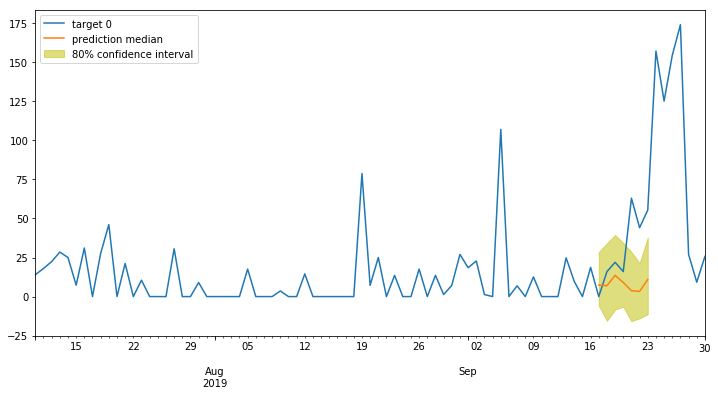

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 1
RMSE: 248.34253590838998
MAE: 210.63743547711428
Target Mean: 677.7428571428571
                y_pred  y_label
2019-09-17  728.054810    700.3
2019-09-18  769.267822    511.4
2019-09-19  745.931274    435.7
2019-09-20  690.862549    535.6
2019-09-21  646.860352    864.7
2019-09-22  688.967102   1127.3
2019-09-23  636.373047    569.2


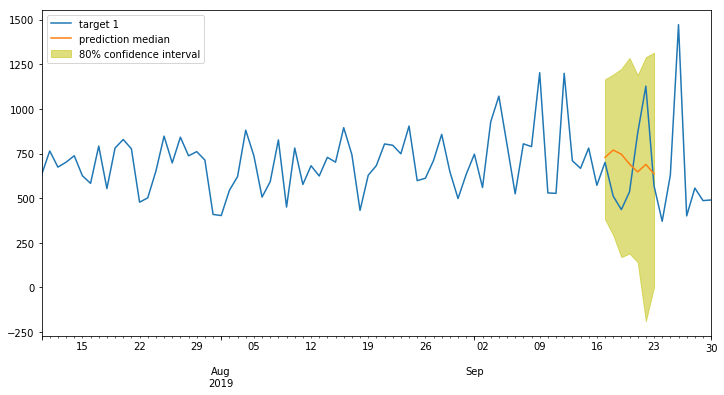

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 2
RMSE: 1143.431995403119
MAE: 981.7461007254427
Target Mean: 1133.4714285714285
                 y_pred  y_label
2019-09-17  1533.762817   1289.6
2019-09-18  1967.685791   1014.5
2019-09-19  2195.010254    800.9
2019-09-20  1855.985229   1001.1
2019-09-21  2124.548340   1341.9
2019-09-22  2073.969727   1590.1
2019-09-23  3055.560547    896.2


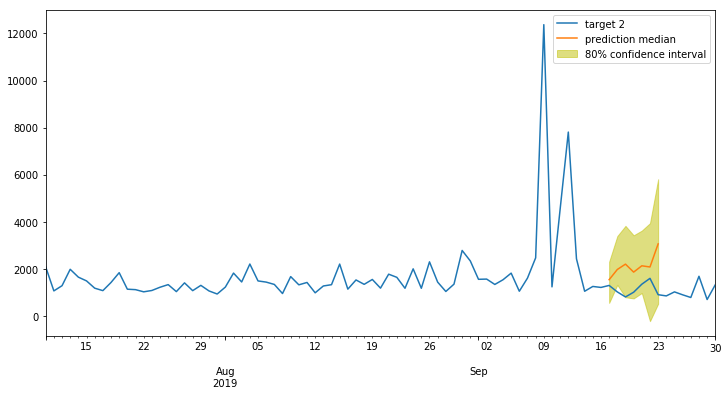

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 3
RMSE: 160.59527026975914
MAE: 120.52632882254287
Target Mean: 664.4714285714284
                y_pred  y_label
2019-09-17  712.008545    660.9
2019-09-18  765.579895    573.8
2019-09-19  761.086609    774.1
2019-09-20  797.057739    732.0
2019-09-21  952.318787    637.3
2019-09-22  759.407043    774.0
2019-09-23  692.312988    499.2


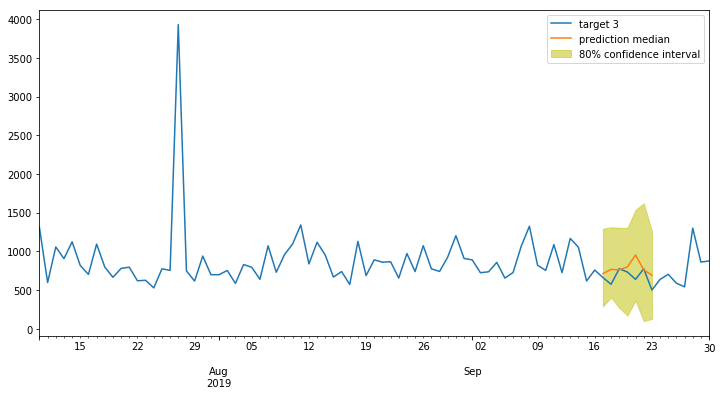

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 4
RMSE: 280.37554852970936
MAE: 221.41696777345717
Target Mean: 825.9857142857144
                y_pred  y_label
2019-09-17  846.172974    750.3
2019-09-18  674.148376    942.1
2019-09-19  751.701782    749.8
2019-09-20  729.557983    919.5
2019-09-21  585.638123    802.1
2019-09-22  512.727051   1106.4
2019-09-23  695.815552    511.7


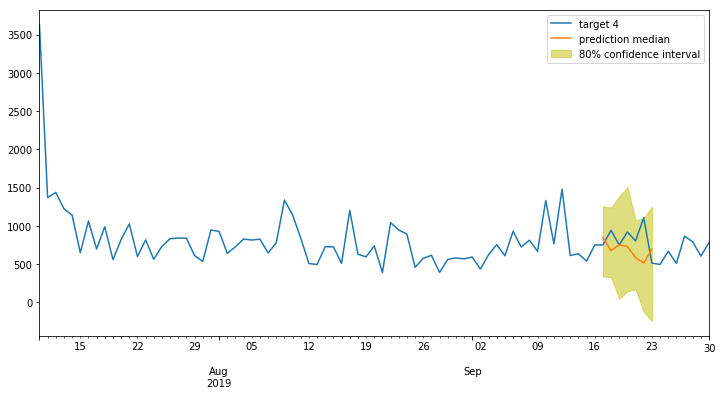

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 5
RMSE: 476.77738554563683
MAE: 377.4744341169
Target Mean: 698.1000000000001
                 y_pred  y_label
2019-09-17  2033.525757    998.2
2019-09-18  1051.169312    779.8
2019-09-19   985.908691    691.3
2019-09-20   565.928650    951.9
2019-09-21   458.756104    426.3
2019-09-22   417.061432    192.5
2019-09-23  1244.728394    846.7


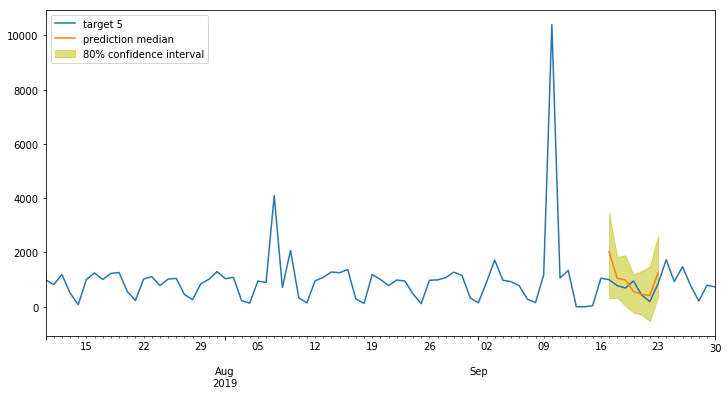

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 6
RMSE: 597.2079771587124
MAE: 529.1527099609285
Target Mean: 1424.357142857143
                 y_pred  y_label
2019-09-17  1646.124634   1173.2
2019-09-18  1569.690796    971.0
2019-09-19  1744.770630   1510.4
2019-09-20  1993.847290   1078.5
2019-09-21  2082.101562   1569.4
2019-09-22  1525.761353   2390.5
2019-09-23  1382.795410   1277.5


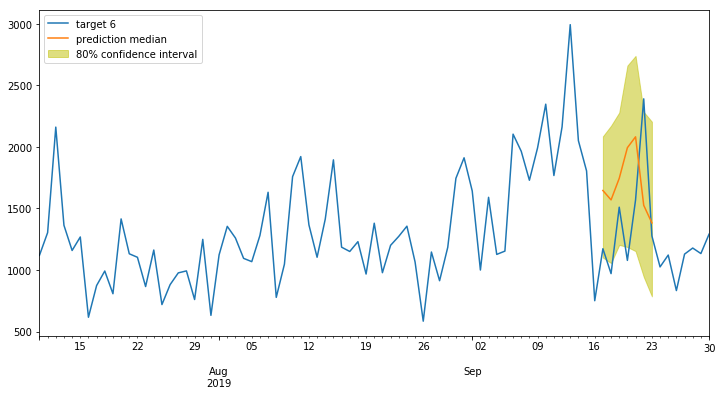

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 7
RMSE: 228.78367860351722
MAE: 193.8464773995429
Target Mean: 779.6285714285715
                 y_pred  y_label
2019-09-17   761.191101    597.5
2019-09-18   800.830627   1206.5
2019-09-19   720.726868    521.8
2019-09-20   842.293030    856.8
2019-09-21   936.504761    823.8
2019-09-22  1121.420410    980.4
2019-09-23   791.005859    470.6


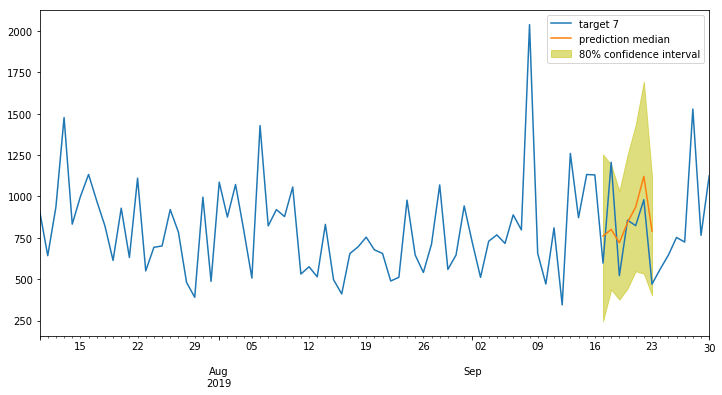

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 8
RMSE: 179.89266974209576
MAE: 136.00495431082857
Target Mean: 924.0571428571429
                 y_pred  y_label
2019-09-17   872.301819    530.7
2019-09-18   969.993408    984.2
2019-09-19  1036.656250    982.4
2019-09-20  1056.633301   1038.4
2019-09-21  1050.534180   1321.9
2019-09-22   994.370850    889.1
2019-09-23   868.800049    721.7


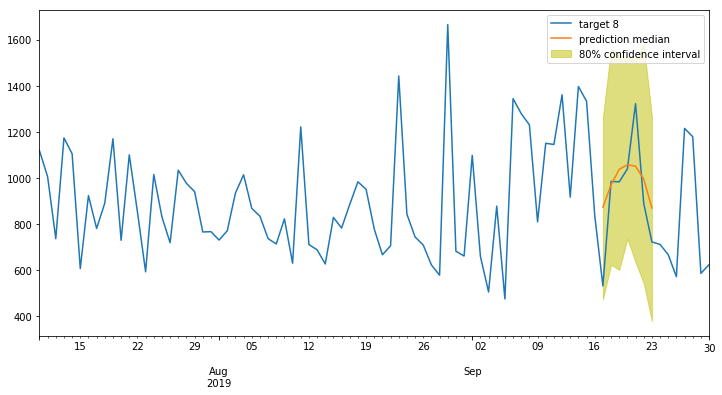

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


i: 9
RMSE: 587.6091029651691
MAE: 499.58219866069993
Target Mean: 2473.714285714286
                 y_pred  y_label
2019-09-17  3132.004150   2786.8
2019-09-18  3688.798096   2534.6
2019-09-19  3334.779541   2657.7
2019-09-20  2657.580566   2998.2
2019-09-21  1807.130493   1998.7
2019-09-22  1865.078247   1618.7
2019-09-23  3263.326416   2721.3


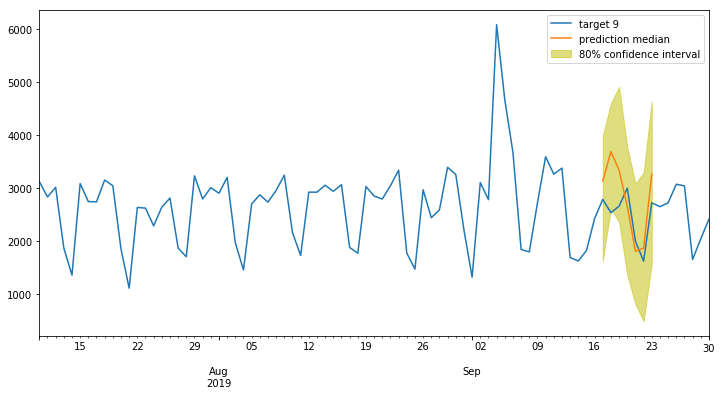

CPU times: user 4.93 s, sys: 56.4 ms, total: 4.98 s
Wall time: 4.92 s


In [354]:
%%time
from sklearn import metrics

def show_metrics(target_quantile='0.5'):
    for i in range(10):  # TODO len(timeseries)
        if preds_new[i] is None:
            continue
        
        s = timeseries[i][start_dataset:end_test-1].fillna(0)
        
        print("i:", i)
        p10 = preds_new[i]['0.1']
        p90 = preds_new[i]['0.9']
        y_label =  timeseries[i][end_training + 1:end_training + 7].fillna(0)
        y_pred = preds_new[i][target_quantile]
        if y_label.shape[0] != y_pred.shape[0]:
            continue
        
        print("RMSE:",np.sqrt(metrics.mean_squared_error(y_label, y_pred)))
        print("MAE:",metrics.mean_absolute_error(y_label, y_pred))
        print("Target Mean:",y_label.mean())
        print(pd.DataFrame({'y_pred': y_pred, 'y_label': y_label}))
        plt.figure(figsize=(12,6))
        s.plot(label='target %s'%str(i))
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        y_pred.plot(label='prediction median')
        plt.legend()
        plt.show()

show_metrics(target_quantile='0.5')

### Delete endpoints

In [318]:
predictor.delete_endpoint()

In [319]:
predictor_new_features.delete_endpoint()